# Лабораторная работа №4. Синтез КИХ-фильтров.
Лаборатория цифровой обработки сигналов, МФТИ

__1 вариант__

| Вариант                                                                	| 0    	| 1 	| 2 	| 3 	| 4 	| 5 	| 6 	|
|:------------------------------------------------------------------------:|:-----:|:-----:|:-----:|:-----:|:-----:|:-----:|:-----:|
| Частота дискретизации $f_s$ Гц                                         	| 2000	| 5000	| 5500	| 6000	| 6500	| 7000	| 7500	|
| граничная частота полосы пропускания $f_1$ Гц                          	| 450  	| 500 	| 650 	| 800 	| 950 	| 1100	| 1250	|
| граничная частота полосы задерживания $f_2$ Гц                         	| 550  	| 750 	| 925 	| 1100	| 1275	| 1450	| 1625	|
| максимально допустимое отклонение АЧХ в полосе пропускания $\delta_1$  	| 0.1  	| 0.05	| 0.05	| 0.05	| 0.05	| 0.05	| 0.05	|
| максимально допустимое отклонение АЧХ в полосе задерживания $\delta_2$ 	| 0.05 	| 0.02 	| 0.02	| 0.02	| 0.02	| 0.02	| 0.02	|

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

In [2]:
# %matplotlib widget

In [3]:
def lin2db(x):
    return 20*np.log10(x + 1e-12)

In [4]:
fs = 5000
f1 = 500
f2 = 750

delta1 = 0.05
delta2 = 0.02

In [5]:
print(f'delta_1 = {lin2db(delta1):.3f} dB\ndelta_2 = {lin2db(delta2):.3f} dB')

delta_1 = -26.021 dB
delta_2 = -33.979 dB


In [6]:
# %matplotlib widget

# Модуль 1. Метод частотной выборки синтеза КИХ-фильтров

## Задача 1.1. Синтез ФНЧ по идеальной АЧХ. 

Синтезировать КИХ-фильтр 28 порядка ($N=29$) на основе идеального фильтра нижних частот с частотой среза $f_c=(f_1+f_2)/2$ методом частотной выборки. Частоту дискретизации принять равной $f_s$.

а) Определить максимальные уровни пульсаций $\delta_1$ и $\delta_2$ в полосе пропускания и в полосе задерживания. 

б) Изобразить на одном графике АЧХ фильтра и отсчеты ДПФ. 

в) Построить импульсную характеристику КИХ-фильтра. Определить по виду импульсной характеристики, будет ли фильтр обладать постоянной фазовой и группой задержками.

г) Получить график для групповой задержки фильтра. Сравнить с выводом в пункте (в).

In [7]:
N = 29
M = 2**12  # for dtft
fc = (f1 + f2) / 2

In [8]:
def ideal_lowpass(N, fc, fs, linear_phase=False):
    n = np.arange(N)
    f = fs * n / N
    H = np.zeros(N, dtype=np.complex128)
    mask = ((0 <= f) & (f <= fc)) | (((fs - fc) <= f) & (f <= fs))
    H[mask] = 1.0 + 0.0j
    
    if linear_phase:
        H *= np.exp(-1j * np.pi * (N - 1) * n / N)
        
    return H

In [9]:
H_nlp = ideal_lowpass(N=N, fc=fc, fs=fs, linear_phase=False)
h_nlp = np.fft.ifft(H_nlp).real
H_nlp_dtft = np.fft.fft(h_nlp, M)

delta = 1e-6
_, gd_nlp = signal.group_delay((h_nlp, [1]), w=np.linspace(-0.5+delta, 0.5-delta, num=M), fs=1)

Эффективный способ вычисления __групповой задержки__, см. [Lyons], с.830

$\tau_{\text{gd}} := -\dfrac{d\varphi(\omega)}{d\omega}$

$H(\omega) = A(\omega) e^{j\varphi(\omega)}$

$\dfrac{d H(\omega)}{d\omega} = \dfrac{A(\omega)}{d\omega} e^{j\varphi(\omega)} + A(\omega) e^{j \varphi(\omega)} \cdot j \dfrac{d\varphi(\omega)}{d\omega}$

$ \dfrac{j d H(\omega) / d\omega}{H(\omega)} = - \dfrac{d\varphi(\omega)}{d\omega} + \dfrac{jdA(\omega)/d\omega}{A(\omega)}$

$\dfrac{\text{DTFT}\left[k \cdot h[k]\right]}{\text{DTFT}\left[ h[k]\right]} = \tau_{\text{gd}} + \dfrac{jdA(\omega)/d\omega}{A(\omega)}$

$ \tau_{\text{gd}} = \text{Re} \left[ \dfrac{\text{DFT}\left[k \cdot h[k]\right]}{\text{DFT}\left[ h[k]\right]} \right] $ 

In [10]:
gd_eps = 1e-15
gd_nlp_lyons = np.real(np.fft.fft(np.arange(len(h_nlp)) * h_nlp, n=M)/ (gd_eps + np.fft.fft(h_nlp, n=M)))

In [11]:
# np.allclose(np.fft.fftshift(gd_nlp), gd_nlp_lyons)  # ошибки в окретсностях нулей H

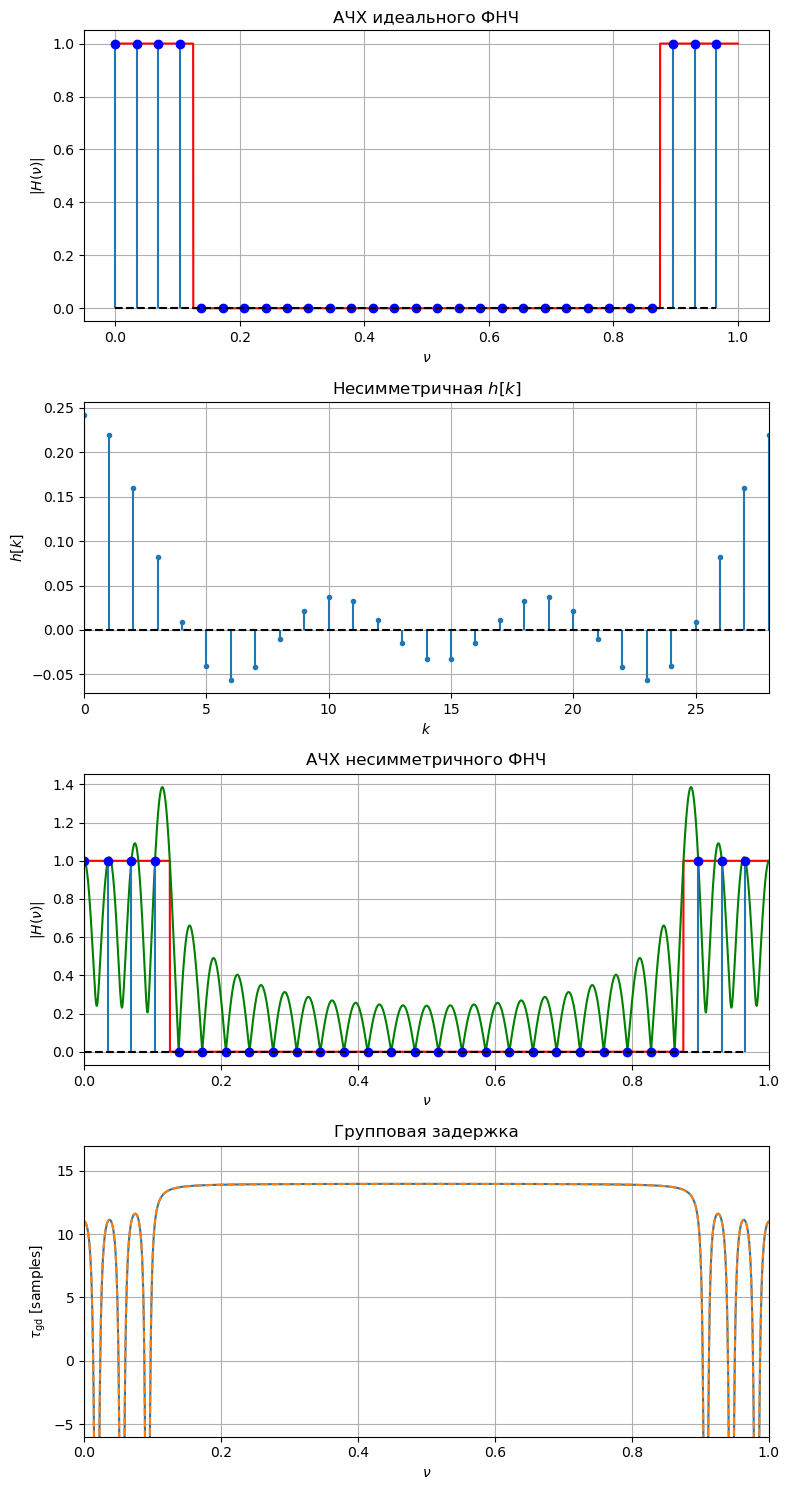

In [12]:
fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(8, 15))
f = np.linspace(0, fs, M)
nu = f / fs

ax[0].set_title('АЧХ идеального ФНЧ')
ax[0].plot(nu, np.abs(ideal_lowpass(M, fc=fc, fs=fs, linear_phase=False)), c='r')
ax[0].stem(np.arange(N)/N, np.abs(H_nlp), markerfmt='bo', basefmt = 'k--')
ax[0].set_xlabel(r'$\nu$'); ax[0].set_ylabel(r'$|H(\nu)|$')
#ax[0].set_xlim([0, fs]); #ax[0].set_ylim([0, None])
ax[0].grid()

ax[1].set_title(r'Несимметричная $h[k]$')
ax[1].stem(h_nlp, markerfmt='.', basefmt = 'k--')
ax[1].set_xlabel(r'$k$'); ax[1].set_ylabel(r'$h[k]$')
ax[1].set_xlim([0, N-1])
ax[1].grid()

ax[2].set_title('AЧХ несимметричного ФНЧ')
ax[2].plot(nu, np.abs(ideal_lowpass(M, fc=fc, fs=fs, linear_phase=False)), c='r')
ax[2].plot(nu, np.abs(H_nlp_dtft), c='g')
ax[2].stem(np.arange(N)/N, np.abs(H_nlp), markerfmt='bo', basefmt = 'k--')
ax[2].set_xlabel(r'$\nu$'); ax[2].set_ylabel(r'$|H(\nu)|$')
ax[2].set_xlim([0, 1]); #ax[0].set_ylim([0, None])
ax[2].grid()

ax[3].set_title('Групповая задержка')
ax[3].plot(nu, gd_nlp_lyons)
ax[3].plot(nu, np.fft.fftshift(gd_nlp), ls='--')
ax[3].set_xlabel(r'$\nu$'); ax[3].set_ylabel(r'$\tau_{\text{gd}}$ [samples]')
ax[3].set_xlim([0, 1]); ax[3].set_ylim([N//2-20, N//2+3])
ax[3].grid()

plt.tight_layout()

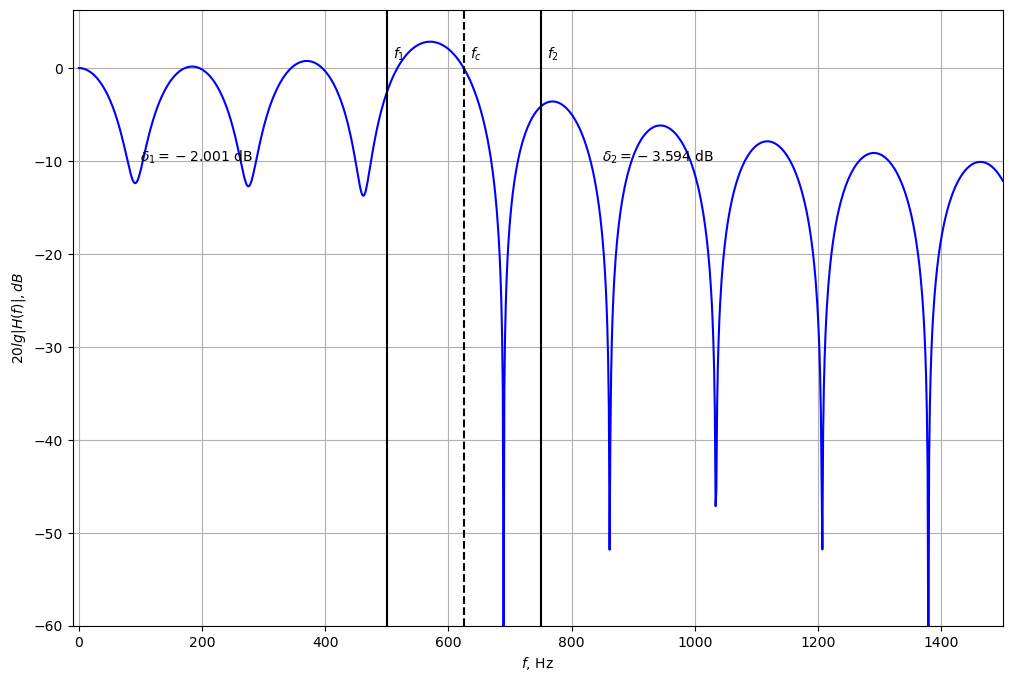

In [13]:
fig = plt.figure(figsize=(12, 8))
fig.patch.set_facecolor('white')
f_band = np.linspace(0, fs, M)
plt.plot(fs*(np.arange(M)/M), lin2db(abs(H_nlp_dtft)), color = 'blue')
plt.axvline(x=fc, ls='--', color='k')
plt.text(x=fc+10, y=1, s='$f_c$')
plt.axvline(x=f1, ls='-', color='k')
plt.text(x=f1+10, y=1, s='$f_1$')
plt.axvline(x=f2, ls='-', color='k')
plt.text(x=f2+10, y=1, s='$f_2$')

my_delta_1 = lin2db(max(abs(abs(H_nlp_dtft[:int(f1/fs*M)])-1)))
plt.text(x=100, y=-10, s=f'$\delta_1={my_delta_1:.3f}$ dB')
my_delta_2 = max(lin2db(abs(H_nlp_dtft[int(f2/fs*M):M//2])))
plt.text(x=f2+100, y=-10, s=f'$\delta_2={my_delta_2:.3f}$ dB')

plt.xlim(xmin=-10,xmax=1500)
plt.ylim(ymin=-60)
plt.xlabel("$f$, Hz")
plt.ylabel("$20lg|H(f)|, dB$")
plt.grid()
plt.show()

## Задача 1.2. Синтез ФНЧ по непрерывной АЧХ.

Синтезировать КИХ-фильтр 28 порядка ($N=29$) на основе идеального фильтра нижних частот с граничной частотой полосы пропускания $f_1$ и с граничной частотой полосы задерживания $f_2$ методом частотной выборки. Частоту дискретизации принять равной $f_s$. Частотную характеристику идеального фильтра в полосе перехода аппроксимировать линейной функцией так, чтобы характеристика была непрерывной.

а) Определить максимальные уровни пульсаций $\delta_1$ и $\delta_2$ в полосе пропускания и в полосе задерживания. Сравнить с результатом в задаче 1.1.

б) Изобразить на одном графике АЧХ фильтра и отсчеты ДПФ. 

в) Построить импульсную характеристику полученного КИХ-фильтра. Определить по виду импульсной характеристики, будет ли 
фильтр обладать постоянной фазовой и группой задержками.

г) Получить график для групповой задержки фильтра. Сравнить с выводом в пункте (в).

д) Определить частоту среза (по уровню $-3$ дБ) модельного и полученного фильтров. 

In [14]:
@np.vectorize
def ideal_lowpass2(f, fs, f1, f2):
    if 0 <= f <= f1 or fs-f1 <= f <=  fs:
        return 1.0
    elif f1 < f < f2: 
        return f/(f1-f2)+(f2/(f2-f1))
    elif fs-f2 < f < fs-f1:
        return f/(f2-f1)+(fs-f2)/(-f2+f1)
    else:
        return 0.0

In [15]:
H_lp = ideal_lowpass2(fs*np.arange(N)/N, f1=f1, f2=f2, fs=fs)
h_lp = np.roll(np.fft.ifft(H_lp).real, N//2)
H_lp_dtft = np.fft.fft(h_lp, M)

delta = 1e-6
_, gd_lp = signal.group_delay((h_lp, [1]), w=np.linspace(-0.5+delta, 0.5-delta, num=M), fs=1)

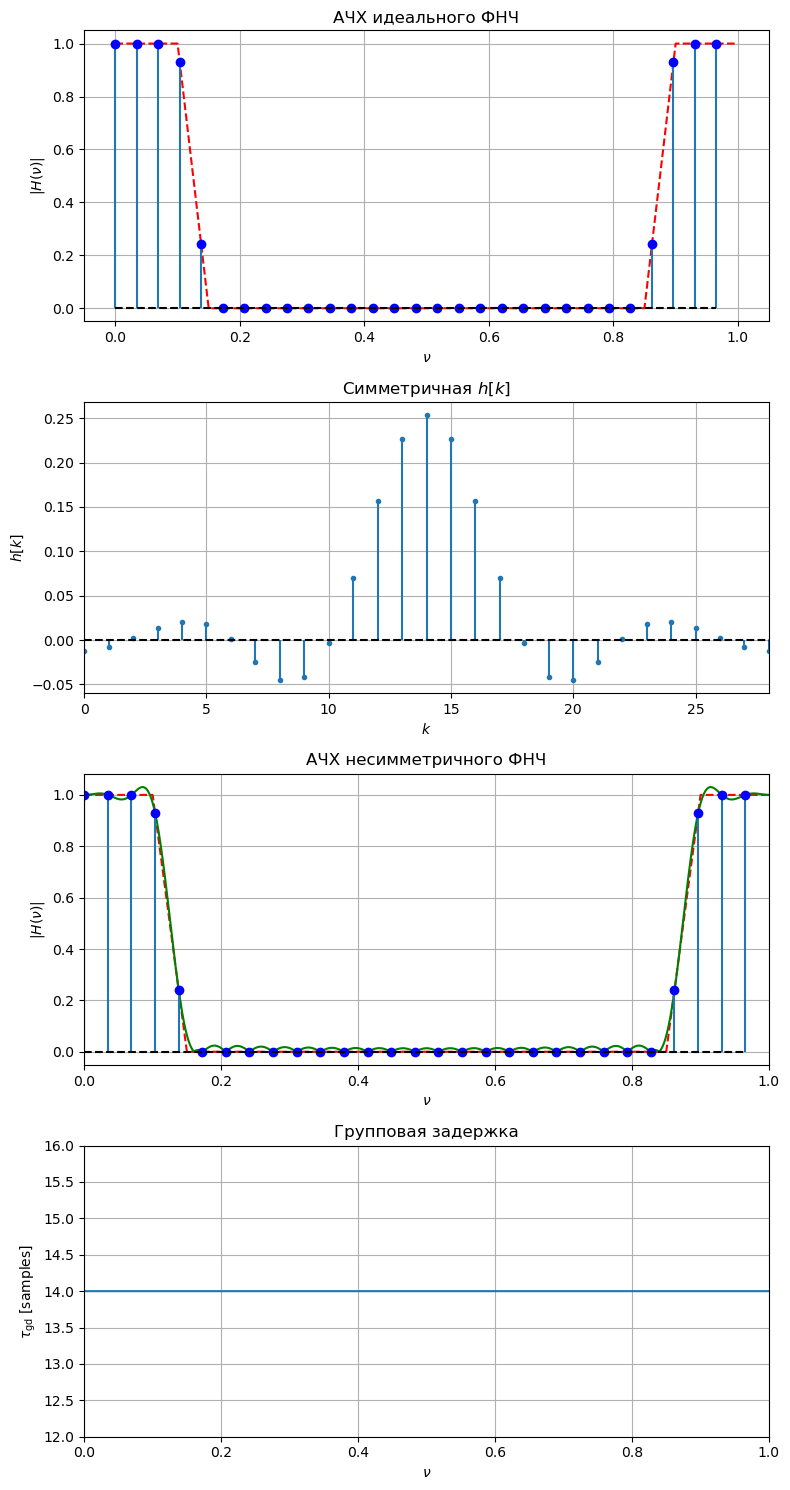

In [16]:
fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(8, 15))
f = np.linspace(0, fs, M)
nu = f / fs

ax[0].set_title('АЧХ идеального ФНЧ')
ax[0].plot(nu, abs(ideal_lowpass2(f_band, f1=f1, f2=f2, fs=fs)), color='r', ls='--')
ax[0].stem(np.arange(N)/N, np.abs(H_lp), markerfmt='bo', basefmt = 'k--')
ax[0].set_xlabel(r'$\nu$'); ax[0].set_ylabel(r'$|H(\nu)|$')
#ax[0].set_xlim([0, fs]); #ax[0].set_ylim([0, None])
ax[0].grid()

ax[1].set_title(r'Cимметричная $h[k]$')
ax[1].stem(h_lp, markerfmt='.', basefmt = 'k--')
ax[1].set_xlabel(r'$k$'); ax[1].set_ylabel(r'$h[k]$')
ax[1].set_xlim([0, N-1])
ax[1].grid()

ax[2].set_title('AЧХ несимметричного ФНЧ')
ax[2].plot(nu, abs(ideal_lowpass2(f_band, f1=f1, f2=f2, fs=fs)), color='r', ls='--')
ax[2].plot(nu, np.abs(H_lp_dtft), c='g')
ax[2].stem(np.arange(N)/N, np.abs(H_lp), markerfmt='bo', basefmt = 'k--')
ax[2].set_xlabel(r'$\nu$'); ax[2].set_ylabel(r'$|H(\nu)|$')
ax[2].set_xlim([0, 1]); #ax[0].set_ylim([0, None])
ax[2].grid()

ax[3].set_title('Групповая задержка')
ax[3].plot(nu, np.fft.fftshift(gd_lp))
ax[3].set_xlabel(r'$\nu$'); ax[3].set_ylabel(r'$\tau_{\text{gd}}$ [samples]')
ax[3].set_xlim([0, 1]); ax[3].set_ylim([N//2-2, N//2+2])
ax[3].grid()

plt.tight_layout()

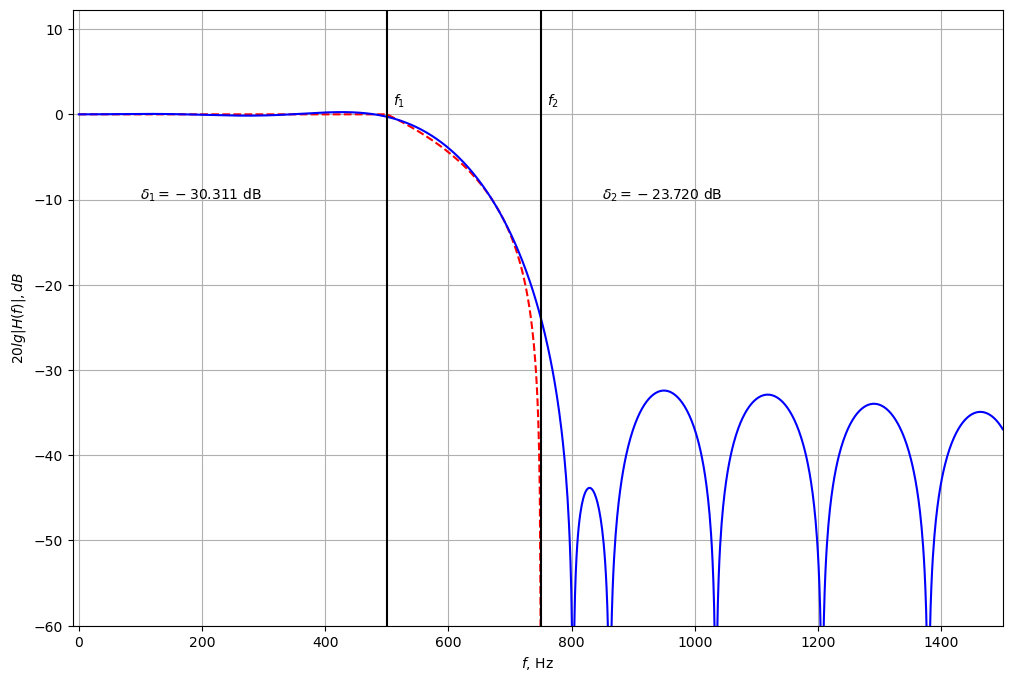

In [17]:
fig = plt.figure(figsize=(12, 8))
f_band = np.linspace(0, fs, M)
plt.plot(f_band, lin2db(abs(ideal_lowpass2(f_band, f1=f1, f2=f2, fs=fs))), color='red', ls='--')
plt.plot(fs*(np.arange(M)/M), lin2db(abs(H_lp_dtft)), color = 'blue')
plt.axvline(x=f1, ls='-', color='k')
plt.text(x=f1+10, y=1, s='$f_1$')
plt.axvline(x=f2, ls='-', color='k')
plt.text(x=f2+10, y=1, s='$f_2$')

my_delta_1 = lin2db(max(abs(abs(H_lp_dtft[:int(f1/fs*M)])-1)))
plt.text(x=100, y=-10, s=f'$\delta_1={my_delta_1:.3f}$ dB')
my_delta_2 = max(lin2db(abs(H_lp_dtft[int(f2/fs*M):M//2])))
plt.text(x=f2+100, y=-10, s=f'$\delta_2={my_delta_2:.3f}$ dB')

plt.xlim(xmin=-10,xmax=1500)
plt.ylim(ymin=-60)
plt.xlabel("$f$, Hz")
plt.ylabel("$20lg|H(f)|, dB$")
plt.grid()
plt.show()

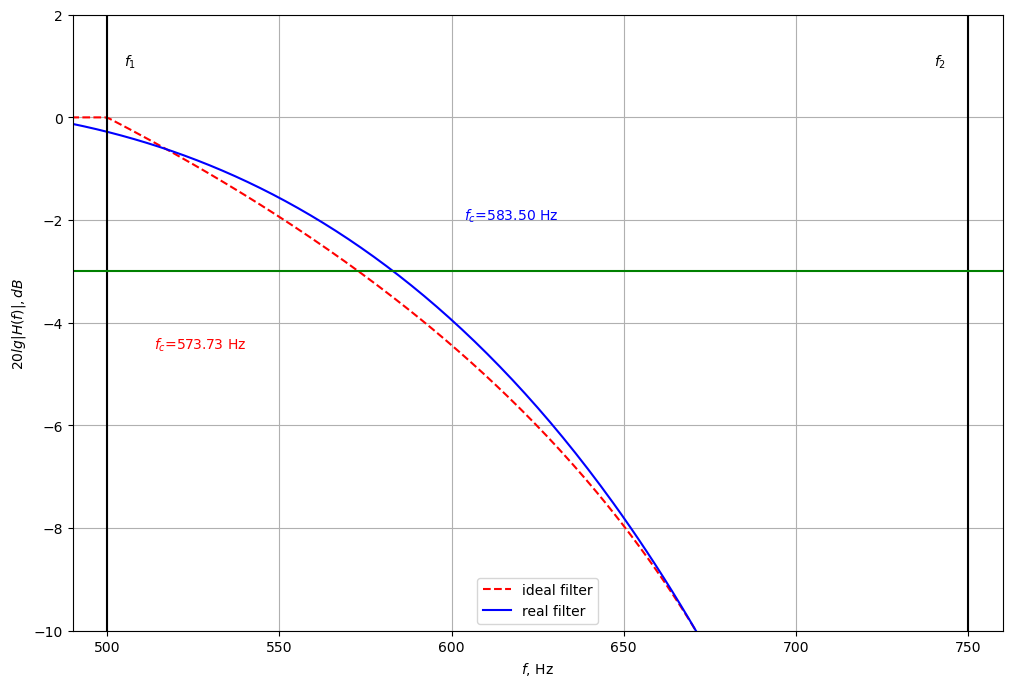

In [18]:
fig = plt.figure(figsize=(12, 8))
plt.plot(f_band, lin2db(abs(ideal_lowpass2(f_band, f1=f1, f2=f2, fs=fs))), color='red', ls='--', label="ideal filter")
plt.plot(fs*(np.arange(M)/M), lin2db(abs(H_lp_dtft)), color = 'blue', label="real filter")
plt.axvline(x=f1, ls='-', color='k')
plt.text(x=f1+5, y=1, s='$f_1$')
plt.axvline(x=f2, ls='-', color='k')
plt.text(x=f2-10, y=1, s='$f_2$')

plt.axhline(y=-3, ls='-', color='green')
Hi_db = lin2db(abs(ideal_lowpass2(f_band, f1=f1, f2=f2, fs=fs)))
fc_ideal = (np.argmin(Hi_db[Hi_db>-3])+1) * fs / M
plt.annotate(xytext=(fc_ideal-60, -4.5), xy=(fc_ideal, -3), 
             text=fr'$f_c$={fc_ideal:.2f} Hz', color='r')
Hr_db = lin2db(abs(H_lp_dtft))
fc_real = (np.argmin(Hr_db[Hr_db>-3])+1) * fs / M
plt.annotate(xytext=(fc_real+20, -2), xy=(fc_real, -3), 
             text=fr'$f_c$={fc_real:.2f} Hz', color='b')

plt.xlim(xmin=f1-10,xmax=f2+10)
plt.ylim(ymax=2,ymin=-10)
plt.xlabel("$f$, Hz")
plt.ylabel("$20lg|H(f)|, dB$")
plt.grid()
plt.legend()
plt.show()

## Задача 1.3*. Синтез фильтра с характеристикой «приподнятый косинус»

Синтезировать КИХ-фильтр 28 порядка ($N=29$) с частотой среза $f_c=(f_1+f_2)/2$  на основе фильтра приподнятого косинуса методом частотной выборки. Частоту дискретизации принять равной $f_s$. На интервале $[-f_s/2, f_s/2]$ частотная характеристика фильтра задается следующим образом 

$$H(f)=\left\{ \begin{matrix}
   1, & |f| < (1-\beta)f_c;\\
   \dfrac{1}{2}\left( 1+\cos \left(\pi \dfrac{|f|-(1-\beta)f_c}{2\beta f_c} \right) \right), & (1-\beta) f_c \le |f| \le (1+\beta)f_c;  \\
   0,   &  |f| > (1+\beta)f_c. \\
\end{matrix} \right.$$

а) Подобрать такое $\beta$, чтобы модельный фильтр не выходил за максимально допустимые отклонения АЧХ в полосе пропускания и в полосе задерживания ($\delta_1$ и $\delta_2$). Изобразить полученную АЧХ фильтра.

б) Для синтезированного фильтра определить максимальные уровни пульсаций $\delta_1$ и $\delta_2$ в полосе пропускания и в полосе задерживания. Сравнить с результатами в задаче 1.1 и задаче 1.2.

в) Изобразить на одном графике АЧХ фильтра и отсчеты ДПФ. 

г) Построить импульсную характеристику полученного КИХ-фильтра. Определить по виду импульсной характеристики, будет ли 
фильтр обладать постоянной фазовой и группой задержками.

д) Получить график для групповой задержки фильтра. Сравнить с выводом в пункте (г).

е) Определить частоту среза (по уровню $-3$ дБ) полученного фильтра. Сравнить с задачей 1.2.


In [19]:
@np.vectorize
def rc_window(f, beta, fc, fs):
    if f > 0.5*fs:
        f = fs - f
    if abs(f) <= (1 - beta) * fc:
        return 1.0
    elif abs(f) > (1 + beta) * fc: 
        return 0.0
    else:
        return 0.5 * (1 + np.cos(np.pi*(abs(f) - (1-beta)*fc)/(2*beta*fc)))

In [20]:
beta=0.2443

In [21]:
print(f'Target:\ndelta_1 = {lin2db(delta1):.3f} dB\ndelta_2 = {lin2db(delta2):.3f} dB')

Target:
delta_1 = -26.021 dB
delta_2 = -33.979 dB


In [22]:
f_band = np.linspace(0, fs, M)
H_rc = rc_window(fs*np.arange(N)/N, beta=beta, fc=fc, fs=fs)
h_rc = np.roll(np.fft.ifft(H_rc).real, N//2)
H_rc_dtft = np.fft.fft(h_rc, M)

delta = 1e-6
_, gd_rc = signal.group_delay((h_rc, [1]), w=np.linspace(-0.5+delta, 0.5-delta, num=M), fs=1)

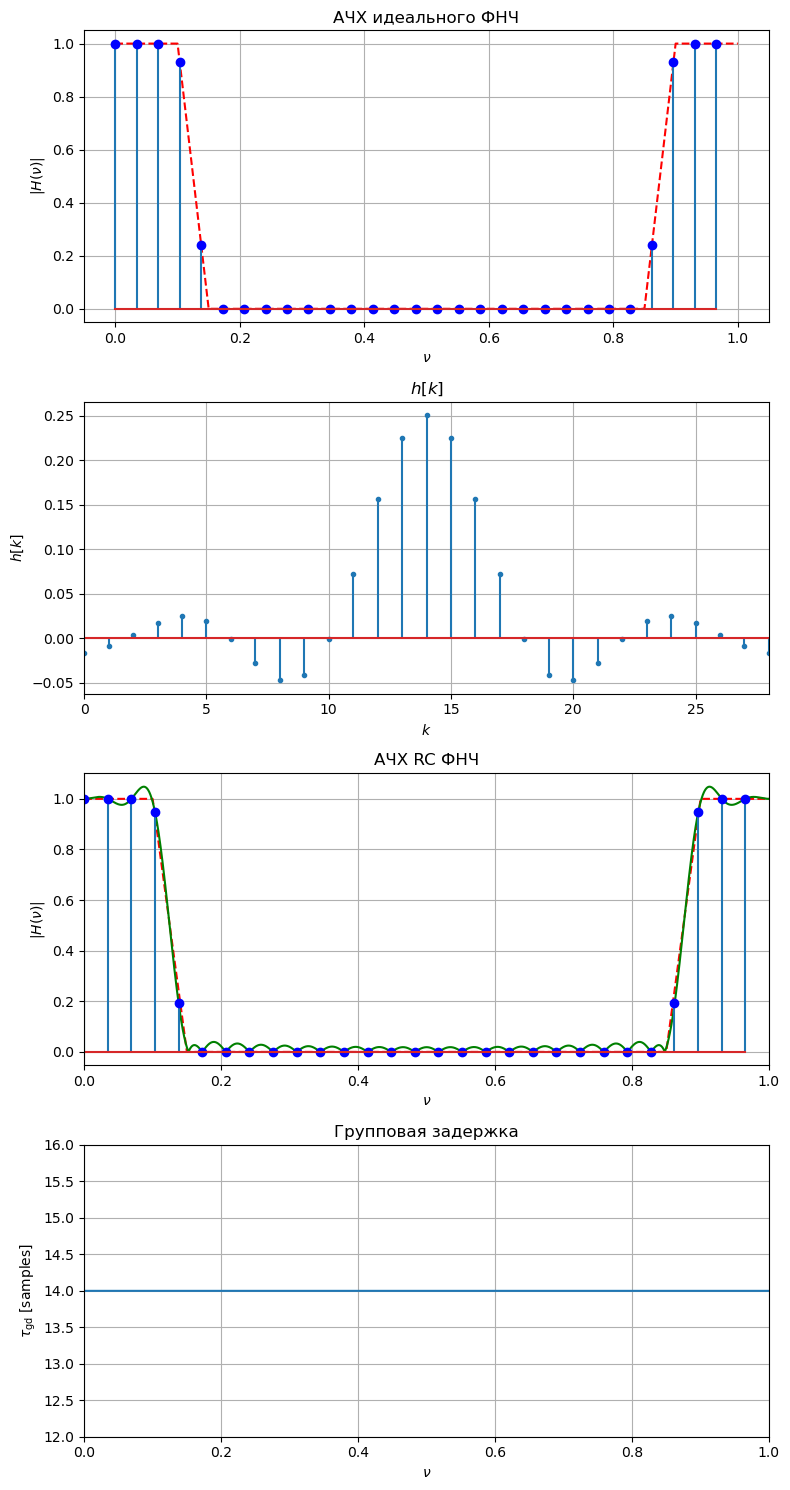

In [23]:
fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(8, 15))
f = np.linspace(0, fs, M)
nu = f / fs

ax[0].set_title('АЧХ идеального ФНЧ')
ax[0].plot(nu, abs(ideal_lowpass2(f_band, f1=f1, f2=f2, fs=fs)), color='r', ls='--')
ax[0].stem(np.arange(N)/N, np.abs(H_lp), markerfmt='bo')
ax[0].set_xlabel(r'$\nu$'); ax[0].set_ylabel(r'$|H(\nu)|$')
#ax[0].set_xlim([0, fs]); #ax[0].set_ylim([0, None])
ax[0].grid()

ax[1].set_title(r'$h[k]$')
ax[1].stem(h_rc, markerfmt='.')
ax[1].set_xlabel(r'$k$'); ax[1].set_ylabel(r'$h[k]$')
ax[1].set_xlim([0, N-1])
ax[1].grid()

ax[2].set_title('AЧХ RC ФНЧ')
ax[2].plot(nu, abs(ideal_lowpass2(f_band, f1=f1, f2=f2, fs=fs)), color='r', ls='--')
ax[2].plot(nu, np.abs(H_rc_dtft), c='g')
ax[2].stem(np.arange(N)/N, np.abs(H_rc), markerfmt='bo')
ax[2].set_xlabel(r'$\nu$'); ax[2].set_ylabel(r'$|H(\nu)|$')
ax[2].set_xlim([0, 1]); #ax[0].set_ylim([0, None])
ax[2].grid()

ax[3].set_title('Групповая задержка')
ax[3].plot(nu, np.fft.fftshift(gd_rc))
ax[3].set_xlabel(r'$\nu$'); ax[3].set_ylabel(r'$\tau_{\text{gd}}$ [samples]')
ax[3].set_xlim([0, 1]); ax[3].set_ylim([N//2-2, N//2+2])
ax[3].grid()

plt.tight_layout()

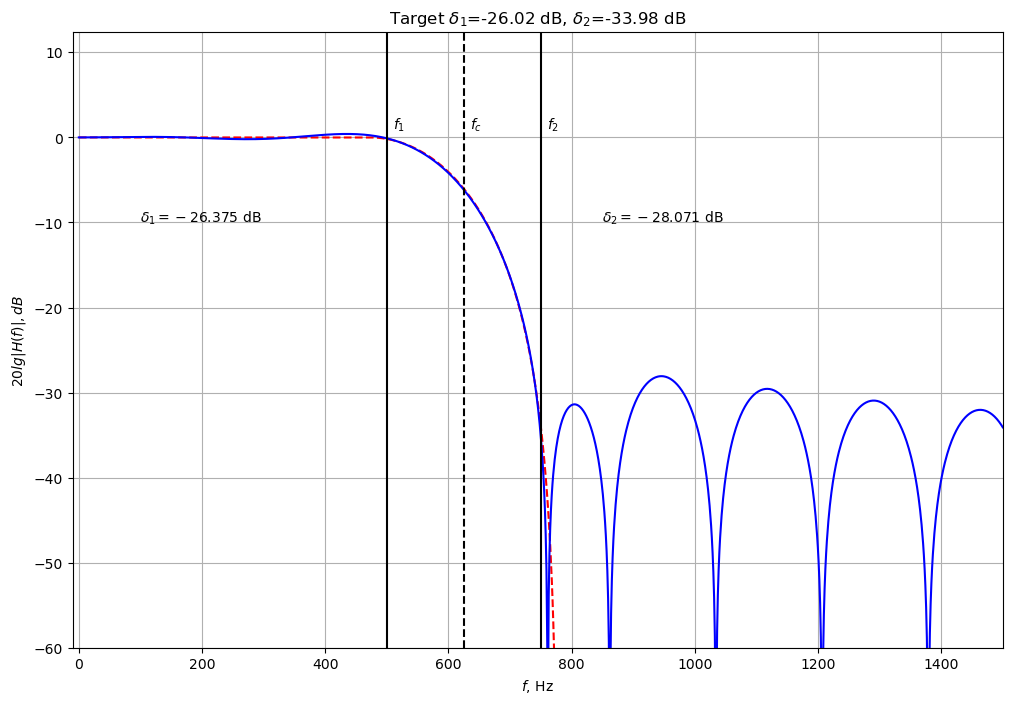

In [24]:
fig = plt.figure(figsize=(12, 8))
fig.patch.set_facecolor('white')
f_band = np.linspace(0, fs, M)
plt.plot(f_band, lin2db(abs(rc_window(f_band, beta=beta, fc=fc, fs=fs))), color='red', ls='--')
plt.plot(fs*(np.arange(M)/M), lin2db(abs(H_rc_dtft)), color = 'blue')
plt.axvline(x=f1, ls='-', color='k')
plt.text(x=f1+10, y=1, s='$f_1$')
plt.axvline(x=fc, ls='--', color='k')
plt.text(x=fc+10, y=1, s='$f_c$')
plt.axvline(x=f2, ls='-', color='k')
plt.text(x=f2+10, y=1, s='$f_2$')

my_delta_1 = lin2db(max(abs(abs(H_rc_dtft[:int(f1/fs*M)])-1)))
plt.text(x=100, y=-10, s=f'$\delta_1={my_delta_1:.3f}$ dB')
my_delta_2 = max(lin2db(abs(H_rc_dtft[int(f2/fs*M):M//2])))
plt.text(x=f2+100, y=-10, s=f'$\delta_2={my_delta_2:.3f}$ dB')

plt.xlim(xmin=-10,xmax=1500)
plt.ylim(ymin=-60)
plt.title(f"Target $\delta_1$={lin2db(delta1):.2f} dB, $\delta_2$={lin2db(delta2):.2f} dB")
plt.xlabel("$f$, Hz")
plt.ylabel("$20lg|H(f)|, dB$")
plt.grid()
plt.show()

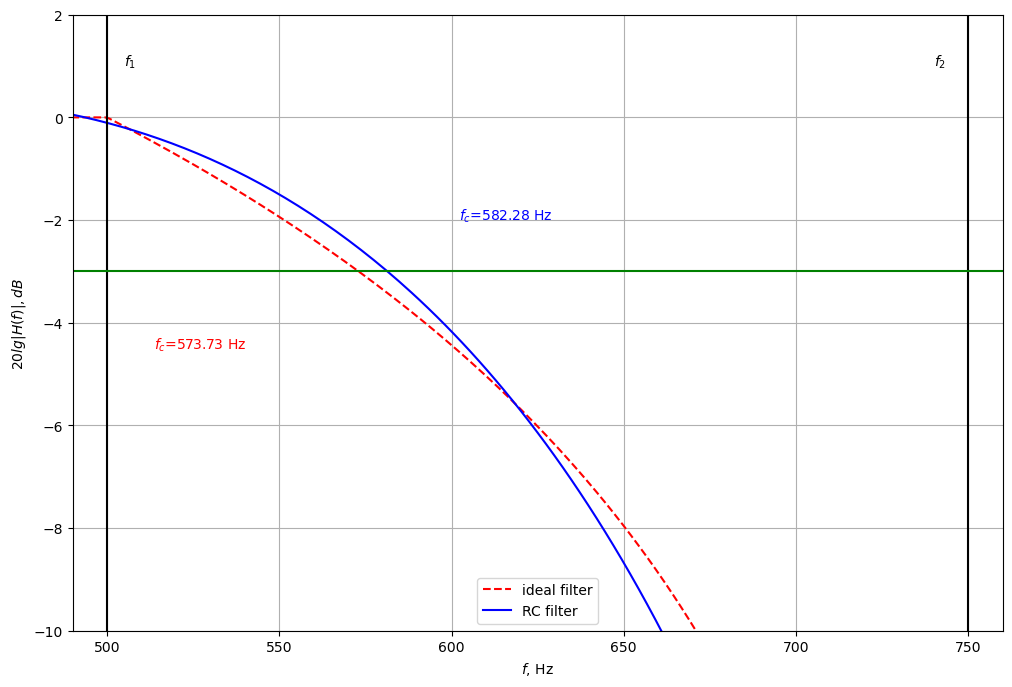

In [25]:
fig = plt.figure(figsize=(12, 8))
plt.plot(f_band, lin2db(abs(ideal_lowpass2(f_band, f1=f1, f2=f2, fs=fs))), color='red', ls='--', label="ideal filter")
plt.plot(fs*(np.arange(M)/M), lin2db(abs(H_rc_dtft)), color = 'blue', label="RC filter")
plt.axvline(x=f1, ls='-', color='k')
plt.text(x=f1+5, y=1, s='$f_1$')
plt.axvline(x=f2, ls='-', color='k')
plt.text(x=f2-10, y=1, s='$f_2$')

plt.axhline(y=-3, ls='-', color='green')
Hi_db = lin2db(abs(ideal_lowpass2(f_band, f1=f1, f2=f2, fs=fs)))
fc_ideal = (np.argmin(Hi_db[Hi_db>-3])+1) * fs / M
plt.annotate(xytext=(fc_ideal-60, -4.5), xy=(fc_ideal, -3), 
             text=fr'$f_c$={fc_ideal:.2f} Hz', color='r')
Hr_db = lin2db(abs(H_rc_dtft))
fc_real = (np.argmin(Hr_db[Hr_db>-3])+1) * fs / M
plt.annotate(xytext=(fc_real+20, -2), xy=(fc_real, -3), 
             text=fr'$f_c$={fc_real:.2f} Hz', color='b')

plt.xlim(xmin=f1-10,xmax=f2+10)
plt.ylim(ymax=2,ymin=-10)
plt.xlabel("$f$, Hz")
plt.ylabel("$20lg|H(f)|, dB$")
plt.grid()
plt.legend()
plt.show()

#  Модуль 2. Метод окон для синтеза КИХ-фильтров

### Задача 2.1. Сравнение АЧХ фильтров одного порядка 
Синтезировать КИХ-фильтры нижних частот c частотой среза $f_c$ при частоте дискретизации $f_s$ порядка $R=28$ ($N=29$) с использованием следующих окон:

* прямоугольное (окно Дирихле)
$$w[k]=\left\{ \begin{matrix}
   1,  \\
   0,  \\
\end{matrix}\begin{matrix}
   \ \ 0\le k\le N-1;  \\
   \left\{ k<0 \right\}\cup \left\{ k\ge N \right\}.  \\
\end{matrix} \right.$$

* окно Ханна 
$$w[k]=\left\{ \begin{matrix}
   0,5-0,5\cos \dfrac{2\pi k}{N-1}, & 0\le k\le N-1;  \\
   0, &\left\{ k<0 \right\}\cup \left\{ k\ge N \right\}. \\
\end{matrix} \right.$$

* окно Хэмминга
$$w[k]=\left\{ \begin{matrix}
   0,54-0,46\cos \dfrac{2\pi k}{N-1}, & 0\le k\le N-1;  \\
   0, &\left\{ k<0 \right\}\cup \left\{ k\ge N \right\}. \\
\end{matrix} \right.$$

* окно Блэкмана
$$w[k]=\left\{ \begin{matrix}
   0,42-0,5\cos \dfrac{2\pi k}{N-1}+0,08\cos \dfrac{4\pi k}{N-1}, & 0\le k\le N-1;  \\
   0, &\left\{ k<0 \right\}\cup \left\{ k\ge N \right\}. \\
\end{matrix} \right.$$

Построить графики оконной функции $w[k]$, импульсной характеристики КИХ-фильтра $h[k]$, АЧХ КИХ-фильтра(в линейном масштабе и в дБ). Определить по графикам максимальный уровень пульсаций по полосе задерживания в дБ. Заполнить таблицу.

|Окно, применяемое для синтеза фильтра |Частота среза, по уровню -3дБ, Гц |Максимальный уровень пульсаций, дБ | Ширина переходной зоны, Гц |
|:-------:|:-|:-|:-|
|Дирихле  |594|-20|140|
|Ханна    |548|-44|376|
|Хэмминга |554|-52|400|
|Блэкмана |533|-75|718|



In [26]:
def plot_window_specs(h_dict, M, f1, f2, fs, delta1, delta2):
    plt.figure(figsize=[10, 5])
    for name, h in h_dict.items():
        H1=abs(np.fft.fftshift(np.fft.fft(h, M)))
        plt.plot(fs*(np.arange(M)/M-0.5), H1, label=name)
    plt.grid()
    plt.ylabel('$|H(f)|$')
    plt.xlabel('$f$ [Hz]')
    plt.title('АЧХ')
    plt.xlim([-fs/2, fs/2])
    plt.ylim([0.0, 1.2])
    plt.hlines(y=1/np.sqrt(2), xmin=-fs/2, xmax=fs/2, ls='--', lw=1, colors='k')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    plt.figure(figsize=[10, 5])
    for name, h in h_dict.items():
        H1=abs(np.fft.fftshift(np.fft.fft(h, M)))
        plt.plot(fs*(np.arange(M)/M-0.5), 20*np.log10(H1), label=name)
    plt.grid()
    plt.ylabel('$|H(f)| [dB]$')
    plt.xlabel('$f$ [Hz]')
    plt.title('АЧХ')
    plt.xlim([-fs/2, fs/2])
    plt.hlines(y=-3, xmin=-fs/2, xmax=fs/2, ls='--', lw=1, colors='k')
    plt.tight_layout()
    plt.show()


#### Окно Дирихле

In [27]:
def boxcar_window(N, nu_c):
    M = N if N % 2 == 1 else N + 1
    k = np.arange(-(M//2), M//2+1)
    res = np.zeros(M)
    res[:M//2] = np.sin(2*np.pi*nu_c*k[:M//2])/(np.pi*k[:M//2])
    res[M//2] = 2 * nu_c
    res[M//2+1:] = np.sin(2*np.pi*nu_c*k[M//2+1:])/(np.pi*k[M//2+1:])
    res /= sum(res)
    return res

In [28]:
h_dir = signal.firwin(numtaps=N, cutoff=fc, width=None, window='boxcar', pass_zero='lowpass', fs=fs)
np.allclose(h_dir, boxcar_window(N, fc/fs))  # фильтры совпадают

True

#### Окно Ханна

In [29]:
h_hann = signal.firwin(numtaps=N, cutoff=fc, width=None, window='hann', pass_zero='lowpass', fs=fs)

#### Окно Хэмминга

In [30]:
h_hamming = signal.firwin(numtaps=N, cutoff=fc, width=None, window='hamming', pass_zero='lowpass', fs=fs)

#### Окно Блэкмана

In [31]:
h_blackman = signal.firwin(numtaps=N, cutoff=fc, width=None, window='blackman', pass_zero='lowpass', fs=fs)

Графики

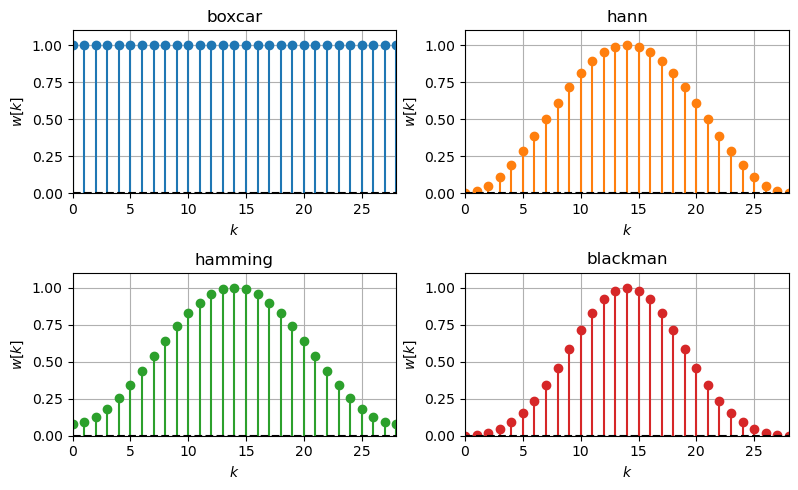

In [32]:
colors={'boxcar':'C0', 'hann':'C1', 'hamming':'C2', 'blackman':'C3'}

fig, ax = plt.subplots(2, 2, figsize=(8, 5))
ax = ax.flatten()
for i, window in enumerate(colors):
    w = signal.get_window(window=window, Nx=N, fftbins=False)
    ax[i].stem(np.arange(N), w, linefmt=colors[window], basefmt = 'k--', markerfmt= colors[window]+'o')
    ax[i].grid()
    ax[i].set_title(window)
    ax[i].set_ylabel('$w[k]$')
    ax[i].set_xlabel('$k$')
    ax[i].set_xlim([0, N-1]); ax[i].set_ylim([0, 1.1])
   
plt.tight_layout()    
plt.show()

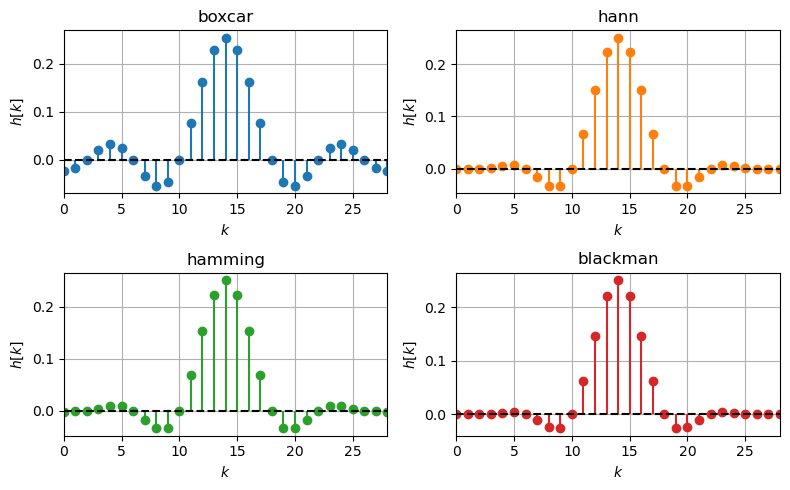

In [33]:
colors={'boxcar':h_dir, 'hann':h_hann, 'hamming':h_hamming, 'blackman':h_blackman}

fig, ax = plt.subplots(2, 2, figsize=(8, 5))
ax = ax.flatten()
for i, (name, h) in enumerate(colors.items()):
    ax[i].stem(np.arange(N), h, linefmt='C'+str(i), basefmt = 'k--', markerfmt='C'+str(i)+'o')
    ax[i].grid()
    ax[i].set_title(name)
    ax[i].set_ylabel('$h[k]$')
    ax[i].set_xlabel('$k$')
    ax[i].set_xlim([0, N-1])
   
plt.tight_layout()    
plt.show()

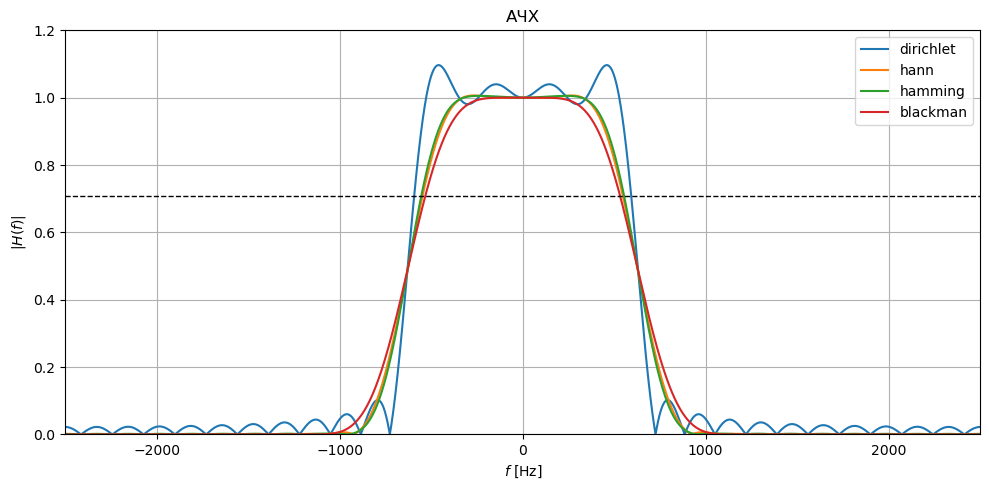

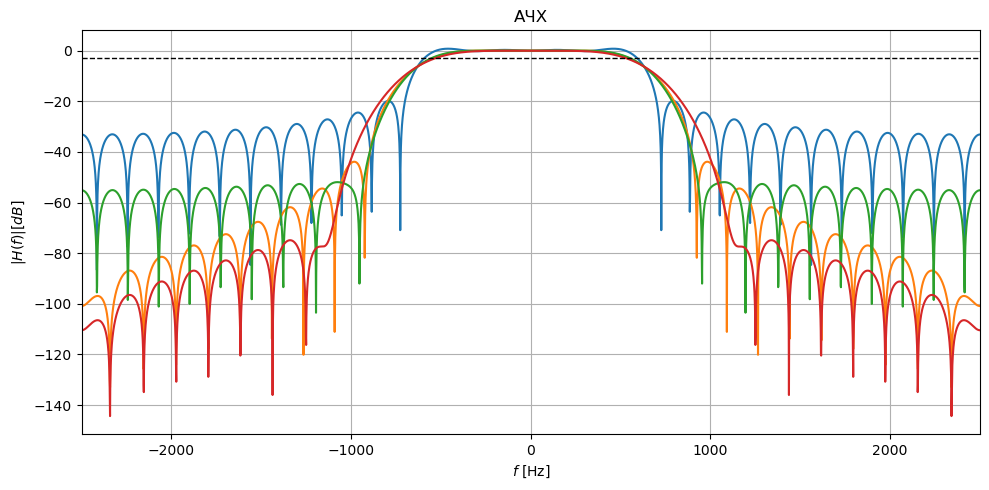

In [34]:
windows_to_plot = {
    'dirichlet' : h_dir,
    'hann' : h_hann,
    'hamming' : h_hamming,
    'blackman' : h_blackman
}
plot_window_specs(windows_to_plot, M=M, f1=f1, f2=f2, fs=fs, delta1=delta1, delta2=delta2)

### Задача 2.2. Синтез ФНЧ с окном Хемминга. 

Синтезировать КИХ-фильтр нижних частот с окном Хемминга наименьшего порядка при заданных требованиях к АЧХ:
* частота дискретизации $f_s$,
* граничная частота полосы пропускания $f_1$,
* граничная частота полосы задерживания $f_2$,
* максимально допустимое отклонение АЧХ в полосе пропускания $\delta_1$,
* максимально допустимое отклонение АЧХ в полосе задерживания $\delta_2$.

Воспользоваться следующей итерационной процедурой [1]:

1) Оценить длину окна по формуле 

$$\hat{N}=\left[\dfrac{3,3 f_s}{\Delta f} \right], \;\;  \Delta f=f_2-f_1$$

2) Взвесить импульсную характеристику идеального фильтра c ФЧХ $\varphi(\theta)=- \dfrac{R}{2} \theta$ окном Хэмминга выбранной длины (``scipy.firwin``, $f_c=(f_1+f_2)/2$).

$$h[k]=\left\{ \begin{matrix}
   {{h}_{\text{ideal}}}[k]w[k],  \\
   0,  \\
\end{matrix}\begin{matrix}
   \ \ 0\le k\le N-1;  \\
   \left\{ k<0 \right\}\cup \left\{ k\ge N \right\}.  \\
\end{matrix} \right.$$

$$w[k]=\left\{ \begin{matrix}
   0,54-0,46\cos \dfrac{2\pi k}{N-1}, & 0\le k\le N-1;  \\
   0, &\left\{ k<0 \right\}\cup \left\{ k\ge N \right\}. \\
\end{matrix} \right.$$

3) Проверить выполнение требований к АЧХ фильтра. Если требования не выполняются, следует увеличить порядок фильтра $R$ (на некоторое целое число) и перейти на п. 2. Если требования выполняются, то нужно уменьшить порядок фильтра  $R$ и перейти на п. 2. Уменьшение и увеличение порядка производится до тех пор, пока не будет найден минимальный порядок , при котором выполняются требования к АЧХ и уменьшение порядка на единицу приводит к нарушению требований к фильтру. 

Проверку требований к АЧХ можно произвести по графику, используя
* backend notebook `%matplotlib notebook` (в Jupyter Notebook)
* `plt.xlim()` и `plt.ylim()` (в Google Colab или в Jupyter Notebook)

Приведите графики АЧХ КИХ-фильтра с начальным ($\hat{R}=\hat{N}-1$) и конечным $R_\text{min}$ порядками в итерационной процедуре. 
______

[1] Солонина, А. И. Цифровая обработка сигналов в зеркале MATLAB : учебное пособие / А. И. Солонина .— Санкт-Петербург : БХВ-Петербург, 2021 .— 560 с. — (Учебная литература для вузов).

P.S. Есть в библиотеке МФТИ. 
______

In [35]:
N_hamming = int(2*np.ceil(3.3*fs/(f2 - f1)/2)+1)
print(f"N_hamming = {N_hamming}")

N_hamming = 67


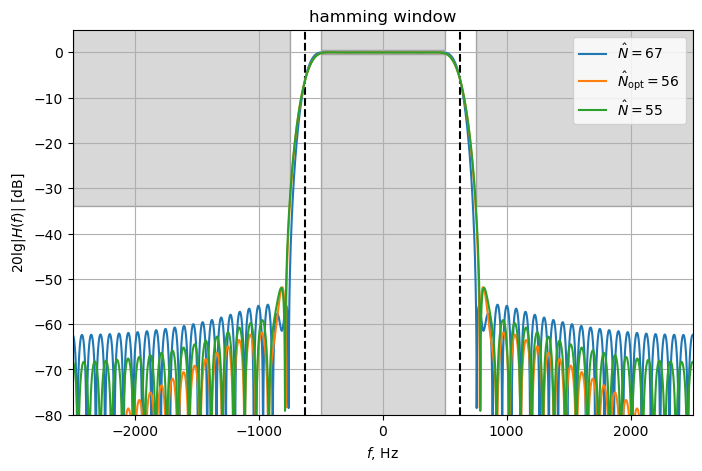

In [36]:
fig, ax = plt.subplots(figsize=(8, 5))
plt.axvline(+fc, ls = '--', color = 'black')
plt.axvline(-fc, ls = '--', color = 'black')

for n in [N_hamming, 56, 55]:
    h = signal.firwin(numtaps=n, cutoff=fc, window='hamming', pass_zero='lowpass', fs=fs)
    H = abs(np.fft.fftshift(np.fft.fft(h, M)))
    plt.plot(fs*(np.arange(M)/M-0.5), lin2db(abs(H)), label = rf'$\hat{{N}} = {n}$' if n!=56 else rf'$\hat{{N}}_{{\text{{opt}}}} = {n}$')


plt.xlim([-fs/2, fs/2])
plt.xlabel("$f$, Hz")
plt.ylabel("$20 \lg |H(f)|$ [dB]")

plt.fill([-f1,-f1, f1, f1], [-100, 20*np.log10(1-delta1), 20*np.log10(1-delta1), -100], 
         edgecolor = 'k', alpha = 0.3, facecolor = 'grey')
plt.fill([-fs/2,-fs/2, -f2, -f2], [20*np.log10(delta2), 10, 10, 20*np.log10(delta2)], 
         edgecolor = 'k', alpha = 0.3, facecolor = 'grey')
plt.fill([f2,f2, fs/2, fs/2], [20*np.log10(delta2), 10, 10, 20*np.log10(delta2)], 
         edgecolor = 'k', alpha = 0.3, facecolor = 'grey')
plt.fill([-f1,-f1, f1, f1], [10, 20*np.log10(1+delta1), 20*np.log10(1+delta1), 10], 
         edgecolor = 'k', alpha = 0.3, facecolor = 'grey')

plt.title("hamming window")
plt.ylim(-80, 5)
plt.grid()
plt.legend(loc='upper right')
plt.show()

## Задача 2.3. Синтез ФНЧ с окном Кайзера.

Синтезировать КИХ-фильтр нижних частот с окном Кайзера наименьшего порядка при заданных требованиях к АЧХ :
* частота дискретизации $f_s$,
* граничная частота полосы пропускания $f_1$,
* граничная частота полосы задерживания $f_2$,
* максимально допустимое отклонение АЧХ в полосе пропускания $\delta_1$,
* максимально допустимое отклонение АЧХ в полосе задерживания $\delta_2$.

Параметр $\beta$ и длину окна $N$ определить по эмпирическим формулам, приведенным в лекции, или с помощью функции `signal.kaiserord`. Привести график АЧХ получившегося фильтра, сравнить порядок с фильтром из задачи 2.2. 

Окно Кайзера
$$w[k]=\left\{ \begin{matrix}
   \dfrac{{{I}_{0}}\left( \beta \sqrt{1-{{\left( \dfrac{2k}{N-1} \right)}^{2}}} \right)}{{{I}_{0}}(\beta )}, & \ \ 0\le k\le N-1;  \\
   0 & \left\{ k<0 \right\}\cup \left\{ k\ge N \right\}.  \\
\end{matrix} \right.$$
где 
* $N$ — длина окна, порядок фильтра $R=N-1$  определяют по эмпирической формуле 
$ R=\left[ \dfrac{{{a}_{\min }}-7,95}{2,285\Delta \theta } \right]$ , где
* * ${{a}_{\min }}$– минимальное заданное затухание КИХ-фильтра в дБ,
* * $\Delta \theta $ - ширина полосы перехода.
* $I_0 (x)$ — модифицированная функция Бесселя первого рода нулевого порядка, которая может быть вычислена с помощью быстро сходящегося степенного ряда (обычно достаточно $L<25$)
$${{I}_{0}}(x)=1+\sum\limits_{m=1}^{L}\,{{\left( \frac{{{\left( x/2 \right)}^{m}}}{m!} \right)}^{2}}$$
* $\beta$ — параметр окна Кайзера, определяемой по эмпирической формуле



$$\beta=\left\{ \begin{matrix}
   0,1102({{a}_{\min }}-8,7), & {{a}_{\min }}>50;  \\
   0.5842{{({{a}_{\min }}-21)}^{0.4}}+0.07886({{a}_{\min }}-21), & 21\le {{a}_{\min }}\le 50;  \\
   0 & {{a}_{\min }}<21.  \\
\end{matrix} \right.$$

In [37]:
N_kaiser = int(np.ceil((-lin2db(delta2) - 7.95) / 2.285 / (2 * np.pi * (f2 - f1)/fs) + 1))
beta = 0.5842*(-lin2db(delta2)-21)**0.4 + 0.07886*(-lin2db(delta2)-21)

print(f"N_kaiser = {N_kaiser}")
print(f"beta = {beta:.3f}")
print(f"delta = {-lin2db(delta2):.3f} [dB]")

N_kaiser = 38
beta = 2.652
delta = 33.979 [dB]


In [38]:
signal.kaiserord(-lin2db(delta2), width=(f2 - f1)/fs*2) == (N_kaiser, beta)

True

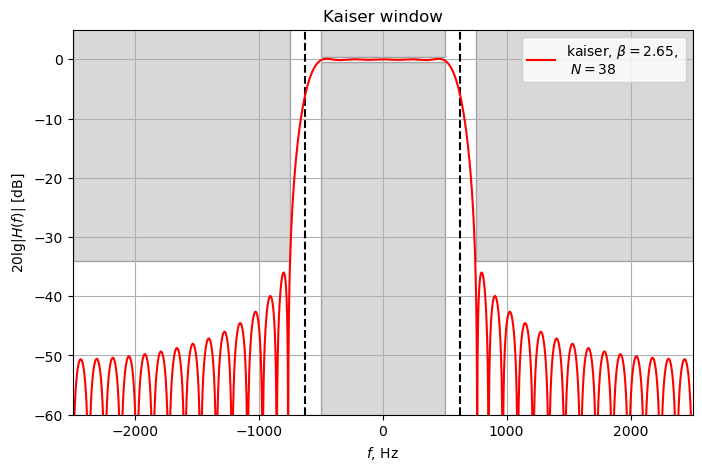

In [39]:
fig, ax = plt.subplots(figsize=(8, 5))

plt.axvline(+fc, ls = '--', color = 'black')
plt.axvline(-fc, ls = '--', color = 'black')

h = signal.firwin(numtaps=N_kaiser, cutoff=fc, window=('kaiser', beta), pass_zero='lowpass', fs=fs)
H=abs(np.fft.fftshift(np.fft.fft(h, M)))
plt.plot(fs*(np.arange(M)/M-0.5), lin2db(abs(H)), color='red', label = f'kaiser, $\\beta = {beta:.2f}$, \n $N = {N_kaiser}$')


plt.xlim([-fs/2, fs/2])
plt.xlabel("$f$, Hz")
plt.ylabel("$20 \lg |H(f)|$ [dB]")

plt.fill([-f1,-f1, f1, f1], [-100, lin2db(1-delta1), 20*np.log10(1-delta1), -100], 
         edgecolor = 'k', alpha = 0.3, facecolor = 'grey')
plt.fill([-fs/2,-fs/2, -f2, -f2], [lin2db(delta2), 10, 10, 20*np.log10(delta2)], 
         edgecolor = 'k', alpha = 0.3, facecolor = 'grey')
plt.fill([f2,f2, fs/2, fs/2], [lin2db(delta2), 10, 10, 20*np.log10(delta2)], 
         edgecolor = 'k', alpha = 0.3, facecolor = 'grey')
plt.fill([-f1,-f1, f1, f1], [10, lin2db(1+delta1), 20*np.log10(1+delta1), 10], 
         edgecolor = 'k', alpha = 0.3, facecolor = 'grey')
plt.title("Kaiser window")
plt.ylim(-60, 5)
plt.grid()
plt.legend(loc='upper right')
plt.show()

#  Модуль 3. Оптимизационные методы синтеза КИХ-фильтров

## Задача 3.1. Метод наименьших квадратов.

Синтезировать КИХ-фильтр методом наименьших квадратов наименьшего порядка при заданных требованиях к АЧХ :
* частота дискретизации $f_s$,
* граничная частота полосы пропускания $f_1$,
* граничная частота полосы задерживания $f_2$,
* максимально допустимое отклонение АЧХ в полосе пропускания $\delta_1$,
* максимально допустимое отклонение АЧХ в полосе задерживания $\delta_2$.

Использовать следующую итерационную процедуру:

1) Выбрать начальный порядок фильтра $R$ (например, можно взять результат решения задачи 2.3).

2) Используя функцию `scipy.signal.firls`, синтезировать КИХ-фильтр порядка $R$ методом наименьших квадратов.

3) Проверить выполнение требований к АЧХ фильтра. Если требования не выпоняются, следует увеличить порядок фильтра $R$ (на некоторое целое число) и перейти на п. 2. Если требования выполняются, то нужно уменьшить порядок фильтра  $R$ и перейти на п. 2. Уменьшение и увеличение порядка производится до тех пор, пока не будет найден минимальный порядок , при котором выполняются требования к АЧХ и уменьшение порядка на единицу приводит к нарушению требований к фильтру. 

Приведите график АЧХ КИХ-фильтра минимального порядка $R_\text{min}$ в итерационной процедуре. 

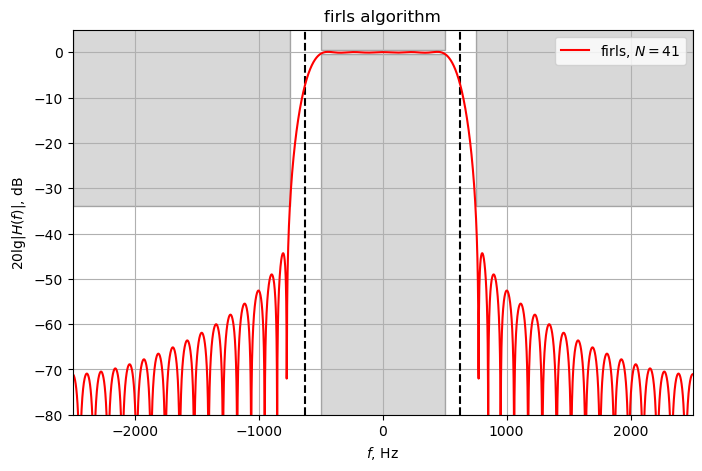

In [40]:
fig, ax = plt.subplots(figsize=(8, 5))

plt.axvline( fc, ls = '--', color = 'black')
plt.axvline(-fc, ls = '--', color = 'black')

bands = np.array([0, f1, f2, fs/2])
desired = np.array([1, 1, 0, 0])
weight = np.array([1/delta1, 1/delta2])  # эвристика

N = 41  # найден при подборе
h = signal.firls(numtaps=N, bands=bands, desired=desired, weight=weight, fs=fs)
H=abs(np.fft.fftshift(np.fft.fft(h, M)))
plt.plot(fs*(np.arange(M)/M-0.5), 20*np.log10(abs(H)), color='red', label = f'firls, $N = {N}$')

plt.xlim([-fs/2, fs/2])
plt.xlabel("$f$, Hz")
plt.ylabel("$20 \lg |H(f)|$, dB")

plt.fill([-f1,-f1, f1, f1], [-100, 20*np.log10(1-delta1), 20*np.log10(1-delta1), -100], 
         edgecolor = 'k', alpha = 0.3, facecolor = 'grey')
plt.fill([-fs/2,-fs/2, -f2, -f2], [20*np.log10(delta2), 10, 10, 20*np.log10(delta2)], 
         edgecolor = 'k', alpha = 0.3, facecolor = 'grey')
plt.fill([f2,f2, fs/2, fs/2], [20*np.log10(delta2), 10, 10, 20*np.log10(delta2)], 
         edgecolor = 'k', alpha = 0.3, facecolor = 'grey')
plt.fill([-f1,-f1, f1, f1], [10, 20*np.log10(1+delta1), 20*np.log10(1+delta1), 10], 
         edgecolor = 'k', alpha = 0.3, facecolor = 'grey')
plt.title("firls algorithm")
plt.ylim(-80, 5)
plt.grid()
plt.legend(loc='upper right')
plt.show()

## Задача 3.2. Метод равномерной чебышевской аппроксимации.

Синтезировать КИХ-фильтр методом равномерной чебышевской аппроксимации наименьшего порядка при заданных требованиях к АЧХ :
* частота дискретизации $f_s$,
* граничная частота полосы пропускания $f_1$,
* граничная частота полосы задерживания $f_2$,
* максимально допустимое отклонение АЧХ в полосе пропускания $\delta_1$,
* максимально допустимое отклонение АЧХ в полосе задерживания $\delta_2$.

Использовать следующую итерационную процедуру:

1) Выбрать начальный порядок фильтра $R$ (например, можно взять результат решения задачи 2.3).

2) Используя функцию `scipy.signal.remez`, синтезировать КИХ-фильтр порядка $R$ методом наименьших квадратов.

3) Проверить выполнение требований к АЧХ фильтра. Если требования не выпоняются, следует увеличить порядок фильтра $R$ (на некоторое целое число) и перейти на п. 2. Если требования выполняются, то нужно уменьшить порядок фильтра  $R$ и перейти на п. 2. Уменьшение и увеличение порядка производится до тех пор, пока не будет найден минимальный порядок , при котором выполняются требования к АЧХ и уменьшение порядка на единицу приводит к нарушению требований к фильтру. 

Приведите график АЧХ КИХ-фильтра минимального порядка $R_\text{min}$ в итерационной процедуре. 

C:\Users\nazmievairat\AppData\Local\Temp\ipykernel_30588\2019718686.py:13: RuntimeWarning: divide by zero encountered in log10
  plt.plot(fs*(np.arange(M)/M-0.5), 20*np.log10(abs(H)), color='red', label = f'remez, $N = {N}$')


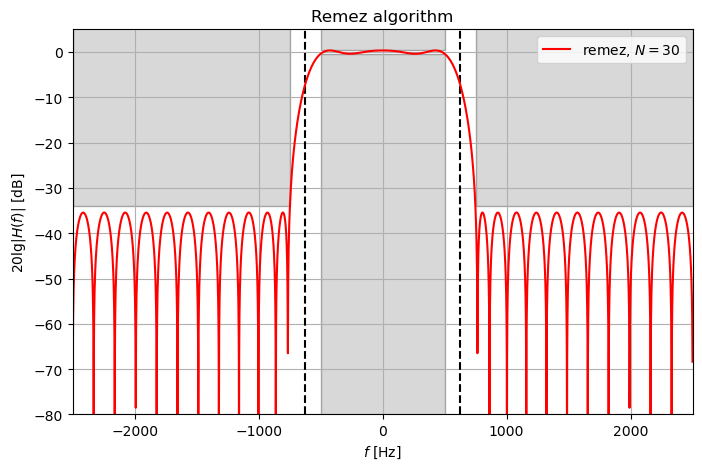

In [41]:
fig, ax = plt.subplots(figsize=(8, 5))

plt.axvline(+fc, ls = '--', color = 'black')
plt.axvline(-fc, ls = '--', color = 'black')

bands = np.array([0, f1, f2, fs/2])
desired = np.array([1, 0])
weight = np.array([1/delta1, 1/delta2])
# N = 30 min
N = 30
h = signal.remez(numtaps=N, bands=bands, desired=desired, weight=weight, fs=fs)
H=abs(np.fft.fftshift(np.fft.fft(h, M)))
plt.plot(fs*(np.arange(M)/M-0.5), 20*np.log10(abs(H)), color='red', label = f'remez, $N = {N}$')

plt.xlim([-fs/2, fs/2])
plt.xlabel("$f$ [Hz]")
plt.ylabel("$20 \lg |H(f)|$ [dB]")

plt.fill([-f1,-f1, f1, f1], [-100, 20*np.log10(1-delta1), 20*np.log10(1-delta1), -100], 
         edgecolor = 'k', alpha = 0.3, facecolor = 'grey')
plt.fill([-fs/2,-fs/2, -f2, -f2], [20*np.log10(delta2), 10, 10, 20*np.log10(delta2)], 
         edgecolor = 'k', alpha = 0.3, facecolor = 'grey')
plt.fill([f2,f2, fs/2, fs/2], [20*np.log10(delta2), 10, 10, 20*np.log10(delta2)], 
         edgecolor = 'k', alpha = 0.3, facecolor = 'grey')
plt.fill([-f1,-f1, f1, f1], [10, 20*np.log10(1+delta1), 20*np.log10(1+delta1), 10], 
         edgecolor = 'k', alpha = 0.3, facecolor = 'grey')

plt.title("Remez algorithm")
plt.ylim(-80, 5)
plt.grid()
plt.legend(loc='upper right')
plt.show()

## Задача 3.3. Сравнение результатов.

Сравнить минимальные порядки КИХ-фильтров, которые получились в задачах 2.2, 2.3, 3.1 и 3.2. Заполнить таблицу.


|                                             	| $R_\text{min}$ 	| $N_\text{min}$ 	|
|:---------------------------------------------:|:---------:|:---------:|
| Оконный метод (окно Хэмминга)               	|      55   	|    56     	|
| Оконный метод (окно Кайзера)                	|      38   	|     39    	|
| Метод наименьших квадратов                  	|       40  	|     41    	|
| Метод равномерной чебышевской аппроксимации 	|        29 	|      30   	|

Определить, будут ли выполняться требование из этих задач для фильтра минимального из получившихся порядков ($N_{\text{min}} = 30$), построенного методом частотной выборки (как в задаче 1.2).

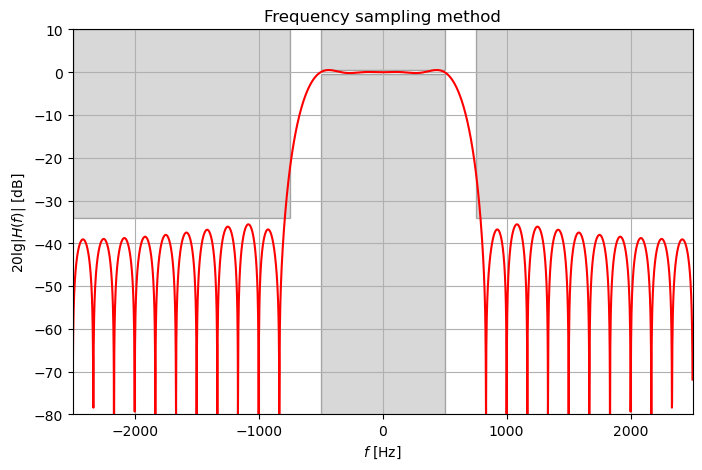

In [42]:
fig = plt.figure(figsize=(8, 5))
H = ideal_lowpass2(fs*(np.arange(N)/N), fs=fs, f1=f1, f2=f2)
h = np.fft.ifftshift(np.fft.ifft(H))
H1 = abs(np.fft.fft(h, M))
plt.plot(fs*(-0.5 + np.arange(M)/M), 20*np.log10(abs(np.fft.fftshift(H1))), color = 'red')

plt.fill([-f1,-f1, f1, f1], [-100, 20*np.log10(1-delta1), 20*np.log10(1-delta1), -100], 
         edgecolor = 'k', alpha = 0.3, facecolor = 'grey')
plt.fill([-fs/2,-fs/2, -f2, -f2], [20*np.log10(delta2), 10, 10, 20*np.log10(delta2)], 
         edgecolor = 'k', alpha = 0.3, facecolor = 'grey')
plt.fill([f2,f2, fs/2, fs/2], [20*np.log10(delta2), 10, 10, 20*np.log10(delta2)], 
         edgecolor = 'k', alpha = 0.3, facecolor = 'grey')
plt.fill([-f1,-f1, f1, f1], [10, 20*np.log10(1+delta1), 20*np.log10(1+delta1), 10], 
         edgecolor = 'k', alpha = 0.3, facecolor = 'grey')

plt.title("Frequency sampling method")
plt.xlim(-fs/2., +fs/2.)
plt.ylim(-80, 10)
plt.xlabel("$f$ [Hz]")
plt.ylabel("$20 \lg |H(f)|$ [dB]")
plt.grid()
plt.show()